# Swapping Cell types
Alyssa's 11/6

Can we swap out different cell types in train/test and get similar accuracy?

Relevent Topics/references
- Snail
- metalearning

# Imports

In [2]:
import collections

import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
# import kipoi TODO kipoi broken
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from scipy import stats

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

# Define Paths for this user

In [3]:
# ########################## PATHS ###########################
# # path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# # data processing


deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"
# dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
# feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

# _DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# # DNase filepath dictionary
# prefix_ =  "/data/akmorrow/encode_data/"

# # get TF logger
# log = logging.getLogger('tensorflow')
# tf_log = "/home/eecs/akmorrow/epitome/dnase/tensorflow_combination.log"
# fh = logging.FileHandler(tf_log)
# fh.setLevel(logging.INFO)
# log.addHandler(fh)

In [4]:
# PATH REQUIRED IN FILES
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

from epitome.functions import *
from epitome.models import *
from epitome.generators import *
from epitome.constants import *

# Load Data

### Load DeepSEA data

In [7]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)


In [8]:
print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4455024, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4455024) (919, 455024)


# Choose cell types and assays

# Choose celltypes

Here we use p300, because we need at least 8 cell types:
- 3 for features in train
- 1 for validation
- 3 new for features in test
- 1 for test in both cases

In [78]:
train_f_celltypes = ['SK-N-MC', 'ProgFib', 'PANC-1', 'NT2-D1', 'NHLF', 'NHEK', 'NHDF-Ad', 'NH-A', 'NB4', 'H1-hESC', 'Gliobla', 'A549']
test_f_celltypes = ['MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HSMMtube', 'HSMM', 'HMEC', 'HCT-116', 'GM12892', 'GM12891', 'GM12878']

test_celltypes = ['SK-N-SH_RA']
validation_cell_types = ['T-47D']

all_eval_cell_types = validation_cell_types + test_celltypes

# Get cell, assay matrix for training

['T-47D', 'SK-N-SH_RA', 'SK-N-MC', 'ProgFib', 'PANC-1', 'NT2-D1', 'NHLF', 'NHEK', 'NHDF-Ad', 'NH-A', 'NB4', 'MCF-7', 'K562', 'HepG2', 'HeLa-S3', 'HUVEC', 'HSMMtube', 'HSMM', 'HMEC', 'HCT-116', 'H1-hESC', 'Gliobla', 'GM12892', 'GM12891', 'GM12878', 'A549'] ['DNase', 'p300', 'eGFP-JunD', 'eGFP-JunB', 'eGFP-HDAC8', 'eGFP-GATA2', 'eGFP-FOS', 'c-Myc', 'c-Jun', 'c-Fos', 'Znf143', 'ZZZ3', 'ZNF274', 'ZNF263', 'ZNF217', 'ZKSCAN1', 'ZEB1', 'ZBTB7A', 'ZBTB33', 'YY1', 'WHIP', 'USF2', 'USF1', 'USF-1', 'UBTF', 'UBF', 'TRIM28', 'TR4', 'THAP1', 'TFIIIC-110', 'TEAD4', 'TCF7L2', 'TCF3', 'TCF12', 'TBP', 'TBLR1', 'TAL1', 'TAF7', 'TAF1', 'Sin3Ak-20', 'SUZ12', 'STAT5A', 'STAT3', 'STAT2', 'STAT1', 'SRF', 'SPT20', 'SP4', 'SP2', 'SP1', 'SMC3', 'SIX5', 'SIRT6', 'SIN3A', 'SETDB1', 'SAP30', 'Rad21', 'RXRA', 'RUNX3', 'RPC155', 'RFX5', 'RBBP5', 'Pol3', 'Pol2-4H8', 'Pol2(phosphoS2)', 'Pol2(b)', 'Pol2', 'Pbx3', 'PU.1', 'PRDM1', 'POU5F1', 'POU2F2', 'PML', 'PLU1', 'PHF8', 'PGC1A', 'PAX5-N19', 'PAX5-C20', 'Nrf1', 'NRSF'

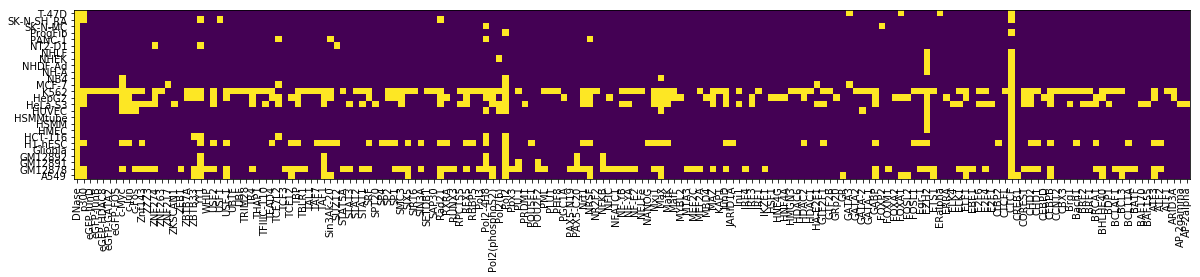

In [81]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', eligible_assays = None,
                                 eligible_cells = train_f_celltypes + test_f_celltypes + all_eval_cell_types , min_assays=2)
        
inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys()), list(assaymap.keys()))

# Select train, valid and test cell types

- test on SK-N-SH_RA
- train/validate on T-47D
- use remaining cell types as feature input 

# Test Data Generator for shuffling cell types

In [82]:
def gen_from_peaks_shuffle_cell_types(data, 
                                      y_index_vectors, 
                                      assay_indices, 
                                      dnase_indices, 
                                      indices, 
                                      radii, 
                                      **kwargs):
    """
    Takes Deepsea data and calculates distance metrics from cell types whose locations
    are specified by y_index_vector, and the other cell types in the set. Label space is only one assay.
    This generator is used to test shuffling cell types.
    
    :param data: dictionary of matrices. Should have keys x and y. x contains n by 1000 rows. y contains n y 919 labels.
    :param y_index_vectors: list of vectors which the indices in the y labels that should be used. 
    :param assay_indices: list of assays that should be used in the label space.
    :param dnase_indices: indices for DNase for celltypes
    :param indices: indices of cell types for the feature space (does not include cell types for eval/test)
    :param radii: where to calculate DNase similarity to.
    
    :returns: generator of data
    """
    # y indices for x and assay indices for y should have the same length
    assert len(y_index_vectors) == len(assay_indices), "Length of y_index_vectors and assay_indices must be the same (# cells evaluatated)"

    batch_size = kwargs["batch_size"]
    matrix = kwargs["matrix"]
    all_eval_cell_types = kwargs["all_eval_cell_types"]
    
    def g():
                    
        if (len(radii) > 0):
            range_ = range(max(radii), data["y"].shape[-1]-max(radii))
        else: 
            range_ = range(0, data["y"].shape[-1])
            
        rec_count = 0
 
        for i in range_: # for all records
            
            for (y_index, assay_index) in zip(y_index_vectors, assay_indices):
                dnases = [] 
                
                # if new batch, permute the cell type orders
                if (rec_count % batch_size == 0):
                    # shuffle the rows, which are the training cell types
                    all_eval_cell_type_indices = list(map(lambda c: cellmap[c], all_eval_cell_types))
                    indices_mat = np.delete(matrix, all_eval_cell_type_indices, axis=0)
                    
                    # shuffle cell types
                    np.random.shuffle(indices_mat)

                    # get all feature locations for DNase for remaining cell types (just the first column in matrix)
                    dnase_indices = indices_mat[:,0] # for all of the cell types (including the cell type we are evaluating)
                    indices = indices_mat[indices_mat!=-1] # remaining indices for cell types not in evaluation or or test

                for radius in radii:
                    
                    # within the radius, fraction of places where they are both 1
                    # y_index[0] == DNase location for specific cell type
                    dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    
                    # within the radius, fraction of places where they are both equal (0 or 1)
                    dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
                                             data["y"][y_index[0],i-radius:i+radius+1], axis=1)
                    dnases.extend(dnase_double_positive)
                    dnases.extend(dnase_agreement)
                    
                rec_count += 1
                    
                # Remove DNase from prediction indices. 
                # You should not predict on assays you use to calculate the distance metric.
                assay_index_no_dnase = np.delete(assay_index, [0])
                yield np.concatenate([data["y"][indices,i],dnases]), data["y"][assay_index_no_dnase,i] 
    return g

In [83]:
exec(open("./generators.py").read())
    
x = make_dataset(train_data,
                 validation_cell_types,
                 all_eval_cell_types + test_f_celltypes,
                 gen_from_peaks_shuffle_cell_types,
                 matrix,
                 assaymap,
                 cellmap,
                 radii=[1,3,10,30],
                 shuffle_size=2,
                 prefetch_size=10,
                 batch_size = 64
                 )


# Run with DNase

In [84]:
exec(open("./generators.py").read())
exec(open("./models.py").read())

# time = datetime.datetime.now().time().strftime("%Y-%m-%d_%H:%M:%S")

# file = open('/data/akmorrow/epitome_data/out/tmp_prediction_metalearn_aucs_%s.py' % time, 'w')


model = MLP(4, [100, 100, 100, 50], 
        tf.tanh, 
        train_data, 
        valid_data, 
        test_data, 
        validation_cell_types,
        test_celltypes,
        gen_from_peaks_shuffle_cell_types, 
        matrix,
        assaymap,
        cellmap,
        shuffle_size=2, 
        all_eval_cell_types=all_eval_cell_types + test_f_celltypes,
        radii=[1,3,10,30],
        batch_size = 64)
model.train(5000)

test_DNase = model.test(455024, mode = Dataset.TEST, log=True)

# save to file
# file.write('test set %f \n' % test_DNase[2])
# file.flush()
print(test_DNase[2])    

batch_size = 64
prefetch_size = 10
shuffle_size = 2

_, new_data = generator_to_one_shot_iterator(make_dataset(test_data,
                 validation_cell_types,
                 all_eval_cell_types + train_f_celltypes,
                 gen_from_peaks_shuffle_cell_types,
                 matrix,
                 assaymap,
                 cellmap,
                  radii=[1,3,10,30],
                 shuffle_size=2,
                 prefetch_size=10,
                 batch_size = 64), batch_size, shuffle_size, prefetch_size)

validation_holdout_indices = np.array([]) 
test_generator = model.test_from_generator(455024, new_data, validation_holdout_indices, log=True)


# save to file
# file.write('test set with  new cell types %f \n' % test_generator[2])
# file.flush()

INFO:tensorflow:Scale of 0 disables regularizer.


/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


INFO:tensorflow:Initializing variables
INFO:tensorflow:Starting Training
INFO:tensorflow:1000 0.080495305
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.5999512624257388
INFO:tensorflow:Our micro AUC:     0.6207594300911966
2019-02-26 12:11:41.318523 0 DNase
INFO:tensorflow:2019-02-26 12:11:41.318658: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.688	avPR:0.020	GINI:0.381
2019-02-26 12:11:41.750795 2 eGFP-JunD
INFO:tensorflow:2019-02-26 12:11:41.750906: 2, eGFP-JunD, NaN
2019-02-26 12:11:41.751652 3 eGFP-JunB
INFO:tensorflow:2019-02-26 12:11:41.751813: 3, eGFP-JunB, NaN
2019-02-26 12:11:41.752508 4 eGFP-HDAC8
INFO:tensorflow:2019-02-26 12:11:41.752602: 4, eGFP-HDAC8, NaN
2019-02-26 12:11:41.753293 5 eGFP-GATA2
INFO:tensorflow:2019-02-26 12:11:41.753353: 5, eGFP-GATA2, NaN
2019-02-26 12:11:41.754086 6 eGFP-FOS
INFO:tensorflow:2019-02-26 12:11:41.754157: 6, eGFP-FOS, NaN
2019-02-26 12:11:41.754842 7 c-Myc
INFO:tensorflow:2019-02-26 12:11:41.754901: 7, c-Myc, NaN
2019-02-2

2019-02-26 12:11:41.801068 84 NF-YB
INFO:tensorflow:2019-02-26 12:11:41.801238: 84, NF-YB, NaN
2019-02-26 12:11:41.801721 85 NF-YA
INFO:tensorflow:2019-02-26 12:11:41.801801: 85, NF-YA, NaN
2019-02-26 12:11:41.802264 86 NF-E2
INFO:tensorflow:2019-02-26 12:11:41.802345: 86, NF-E2, NaN
2019-02-26 12:11:41.802917 87 NELFe
INFO:tensorflow:2019-02-26 12:11:41.802997: 87, NELFe, NaN
2019-02-26 12:11:41.803473 88 NANOG
INFO:tensorflow:2019-02-26 12:11:41.803554: 88, NANOG, NaN
2019-02-26 12:11:41.804015 89 Mxi1
INFO:tensorflow:2019-02-26 12:11:41.804208: 89, Mxi1, NaN
2019-02-26 12:11:41.804696 90 Max
INFO:tensorflow:2019-02-26 12:11:41.804777: 90, Max, NaN
2019-02-26 12:11:41.805265 91 MafK
INFO:tensorflow:2019-02-26 12:11:41.805346: 91, MafK, NaN
2019-02-26 12:11:41.805933 92 MafF
INFO:tensorflow:2019-02-26 12:11:41.806014: 92, MafF, NaN
2019-02-26 12:11:41.806484 93 MYBL2
INFO:tensorflow:2019-02-26 12:11:41.806564: 93, MYBL2, NaN
2019-02-26 12:11:41.807044 94 MTA3
INFO:tensorflow:2019-02-2

2019-02-26 12:11:43.294429 171 AP-2alpha
INFO:tensorflow:2019-02-26 12:11:43.294530: 171, AP-2alpha, NaN
INFO:tensorflow:
INFO:tensorflow:2000 0.15931274
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.5797036841801585
INFO:tensorflow:Our micro AUC:     0.6272431965014222
2019-02-26 12:12:30.712215 0 DNase
INFO:tensorflow:2019-02-26 12:12:30.712311: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.654	avPR:0.022	GINI:0.316
2019-02-26 12:12:31.115442 2 eGFP-JunD
INFO:tensorflow:2019-02-26 12:12:31.115502: 2, eGFP-JunD, NaN
2019-02-26 12:12:31.116281 3 eGFP-JunB
INFO:tensorflow:2019-02-26 12:12:31.116391: 3, eGFP-JunB, NaN
2019-02-26 12:12:31.117149 4 eGFP-HDAC8
INFO:tensorflow:2019-02-26 12:12:31.117221: 4, eGFP-HDAC8, NaN
2019-02-26 12:12:31.117924 5 eGFP-GATA2
INFO:tensorflow:2019-02-26 12:12:31.118011: 5, eGFP-GATA2, NaN
2019-02-26 12:12:31.118720 6 eGFP-FOS
INFO:tensorflow:2019-02-26 12:12:31.118777: 6, eGFP-FOS, NaN
2019-02-26 12:12:31.119467 7 c-Myc
INFO:tensorflow:201

2019-02-26 12:12:31.165685 84 NF-YB
INFO:tensorflow:2019-02-26 12:12:31.165767: 84, NF-YB, NaN
2019-02-26 12:12:31.166234 85 NF-YA
INFO:tensorflow:2019-02-26 12:12:31.166420: 85, NF-YA, NaN
2019-02-26 12:12:31.166896 86 NF-E2
INFO:tensorflow:2019-02-26 12:12:31.166977: 86, NF-E2, NaN
2019-02-26 12:12:31.167455 87 NELFe
INFO:tensorflow:2019-02-26 12:12:31.167536: 87, NELFe, NaN
2019-02-26 12:12:31.168107 88 NANOG
INFO:tensorflow:2019-02-26 12:12:31.168189: 88, NANOG, NaN
2019-02-26 12:12:31.168669 89 Mxi1
INFO:tensorflow:2019-02-26 12:12:31.168753: 89, Mxi1, NaN
2019-02-26 12:12:31.169245 90 Max
INFO:tensorflow:2019-02-26 12:12:31.169410: 90, Max, NaN
2019-02-26 12:12:31.169906 91 MafK
INFO:tensorflow:2019-02-26 12:12:31.169986: 91, MafK, NaN
2019-02-26 12:12:31.170461 92 MafF
INFO:tensorflow:2019-02-26 12:12:31.170543: 92, MafF, NaN
2019-02-26 12:12:31.171124 93 MYBL2
INFO:tensorflow:2019-02-26 12:12:31.171205: 93, MYBL2, NaN
2019-02-26 12:12:31.171693 94 MTA3
INFO:tensorflow:2019-02-2

2019-02-26 12:12:32.618790 171 AP-2alpha
INFO:tensorflow:2019-02-26 12:12:32.618868: 171, AP-2alpha, NaN
INFO:tensorflow:
INFO:tensorflow:3000 0.005750196
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.5720444329333226
INFO:tensorflow:Our micro AUC:     0.6126070138216495
2019-02-26 12:13:20.639692 0 DNase
INFO:tensorflow:2019-02-26 12:13:20.639785: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.612	avPR:0.027	GINI:0.237
2019-02-26 12:13:21.067692 2 eGFP-JunD
INFO:tensorflow:2019-02-26 12:13:21.067754: 2, eGFP-JunD, NaN
2019-02-26 12:13:21.068610 3 eGFP-JunB
INFO:tensorflow:2019-02-26 12:13:21.068669: 3, eGFP-JunB, NaN
2019-02-26 12:13:21.069489 4 eGFP-HDAC8
INFO:tensorflow:2019-02-26 12:13:21.069582: 4, eGFP-HDAC8, NaN
2019-02-26 12:13:21.070461 5 eGFP-GATA2
INFO:tensorflow:2019-02-26 12:13:21.070518: 5, eGFP-GATA2, NaN
2019-02-26 12:13:21.071301 6 eGFP-FOS
INFO:tensorflow:2019-02-26 12:13:21.071369: 6, eGFP-FOS, NaN
2019-02-26 12:13:21.072163 7 c-Myc
INFO:tensorflow:20

2019-02-26 12:13:21.127526 84 NF-YB
INFO:tensorflow:2019-02-26 12:13:21.127606: 84, NF-YB, NaN
2019-02-26 12:13:21.128132 85 NF-YA
INFO:tensorflow:2019-02-26 12:13:21.128215: 85, NF-YA, NaN
2019-02-26 12:13:21.128742 86 NF-E2
INFO:tensorflow:2019-02-26 12:13:21.128823: 86, NF-E2, NaN
2019-02-26 12:13:21.129328 87 NELFe
INFO:tensorflow:2019-02-26 12:13:21.129509: 87, NELFe, NaN
2019-02-26 12:13:21.130032 88 NANOG
INFO:tensorflow:2019-02-26 12:13:21.130114: 88, NANOG, NaN
2019-02-26 12:13:21.130621 89 Mxi1
INFO:tensorflow:2019-02-26 12:13:21.130792: 89, Mxi1, NaN
2019-02-26 12:13:21.131331 90 Max
INFO:tensorflow:2019-02-26 12:13:21.131412: 90, Max, NaN
2019-02-26 12:13:21.131913 91 MafK
INFO:tensorflow:2019-02-26 12:13:21.132106: 91, MafK, NaN
2019-02-26 12:13:21.132630 92 MafF
INFO:tensorflow:2019-02-26 12:13:21.132713: 92, MafF, NaN
2019-02-26 12:13:21.133242 93 MYBL2
INFO:tensorflow:2019-02-26 12:13:21.133417: 93, MYBL2, NaN
2019-02-26 12:13:21.133949 94 MTA3
INFO:tensorflow:2019-02-2

2019-02-26 12:13:22.582635 171 AP-2alpha
INFO:tensorflow:2019-02-26 12:13:22.582690: 171, AP-2alpha, NaN
INFO:tensorflow:
INFO:tensorflow:4000 0.009509628
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.570872884394666
INFO:tensorflow:Our micro AUC:     0.6342850929740199
2019-02-26 12:14:09.481192 0 DNase
INFO:tensorflow:2019-02-26 12:14:09.481270: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.575	avPR:0.028	GINI:0.172
2019-02-26 12:14:09.888828 2 eGFP-JunD
INFO:tensorflow:2019-02-26 12:14:09.888888: 2, eGFP-JunD, NaN
2019-02-26 12:14:09.889633 3 eGFP-JunB
INFO:tensorflow:2019-02-26 12:14:09.889722: 3, eGFP-JunB, NaN
2019-02-26 12:14:09.890482 4 eGFP-HDAC8
INFO:tensorflow:2019-02-26 12:14:09.890564: 4, eGFP-HDAC8, NaN
2019-02-26 12:14:09.891301 5 eGFP-GATA2
INFO:tensorflow:2019-02-26 12:14:09.891356: 5, eGFP-GATA2, NaN
2019-02-26 12:14:09.892106 6 eGFP-FOS
INFO:tensorflow:2019-02-26 12:14:09.892178: 6, eGFP-FOS, NaN
2019-02-26 12:14:09.892909 7 c-Myc
INFO:tensorflow:201

2019-02-26 12:14:09.942617 84 NF-YB
INFO:tensorflow:2019-02-26 12:14:09.942698: 84, NF-YB, NaN
2019-02-26 12:14:09.943204 85 NF-YA
INFO:tensorflow:2019-02-26 12:14:09.943286: 85, NF-YA, NaN
2019-02-26 12:14:09.943799 86 NF-E2
INFO:tensorflow:2019-02-26 12:14:09.943972: 86, NF-E2, NaN
2019-02-26 12:14:09.944587 87 NELFe
INFO:tensorflow:2019-02-26 12:14:09.944671: 87, NELFe, NaN
2019-02-26 12:14:09.945196 88 NANOG
INFO:tensorflow:2019-02-26 12:14:09.945367: 88, NANOG, NaN
2019-02-26 12:14:09.945888 89 Mxi1
INFO:tensorflow:2019-02-26 12:14:09.946069: 89, Mxi1, NaN
2019-02-26 12:14:09.946601 90 Max
INFO:tensorflow:2019-02-26 12:14:09.946759: 90, Max, NaN
2019-02-26 12:14:09.947290 91 MafK
INFO:tensorflow:2019-02-26 12:14:09.947372: 91, MafK, NaN
2019-02-26 12:14:09.947879 92 MafF
INFO:tensorflow:2019-02-26 12:14:09.948065: 92, MafF, NaN
2019-02-26 12:14:09.948614 93 MYBL2
INFO:tensorflow:2019-02-26 12:14:09.948701: 93, MYBL2, NaN
2019-02-26 12:14:09.949219 94 MTA3
INFO:tensorflow:2019-02-2

2019-02-26 12:14:11.361808 171 AP-2alpha
INFO:tensorflow:2019-02-26 12:14:11.361882: 171, AP-2alpha, NaN
INFO:tensorflow:
INFO:tensorflow:5000 0.008571232
INFO:tensorflow:On validation
INFO:tensorflow:Our macro AUC:     0.5463009574783306
INFO:tensorflow:Our micro AUC:     0.6306777018841342
2019-02-26 12:14:58.844904 0 DNase
INFO:tensorflow:2019-02-26 12:14:58.844997: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.594	avPR:0.028	GINI:0.228
2019-02-26 12:14:59.288284 2 eGFP-JunD
INFO:tensorflow:2019-02-26 12:14:59.288348: 2, eGFP-JunD, NaN
2019-02-26 12:14:59.289154 3 eGFP-JunB
INFO:tensorflow:2019-02-26 12:14:59.289215: 3, eGFP-JunB, NaN
2019-02-26 12:14:59.289970 4 eGFP-HDAC8
INFO:tensorflow:2019-02-26 12:14:59.290027: 4, eGFP-HDAC8, NaN
2019-02-26 12:14:59.290726 5 eGFP-GATA2
INFO:tensorflow:2019-02-26 12:14:59.290784: 5, eGFP-GATA2, NaN
2019-02-26 12:14:59.291511 6 eGFP-FOS
INFO:tensorflow:2019-02-26 12:14:59.291576: 6, eGFP-FOS, NaN
2019-02-26 12:14:59.292262 7 c-Myc
INFO:tensorflow:20

2019-02-26 12:14:59.340291 84 NF-YB
INFO:tensorflow:2019-02-26 12:14:59.340371: 84, NF-YB, NaN
2019-02-26 12:14:59.340849 85 NF-YA
INFO:tensorflow:2019-02-26 12:14:59.340930: 85, NF-YA, NaN
2019-02-26 12:14:59.341503 86 NF-E2
INFO:tensorflow:2019-02-26 12:14:59.341583: 86, NF-E2, NaN
2019-02-26 12:14:59.342058 87 NELFe
INFO:tensorflow:2019-02-26 12:14:59.342137: 87, NELFe, NaN
2019-02-26 12:14:59.342600 88 NANOG
INFO:tensorflow:2019-02-26 12:14:59.342776: 88, NANOG, NaN
2019-02-26 12:14:59.343247 89 Mxi1
INFO:tensorflow:2019-02-26 12:14:59.343328: 89, Mxi1, NaN
2019-02-26 12:14:59.343804 90 Max
INFO:tensorflow:2019-02-26 12:14:59.343883: 90, Max, NaN
2019-02-26 12:14:59.344456 91 MafK
INFO:tensorflow:2019-02-26 12:14:59.344537: 91, MafK, NaN
2019-02-26 12:14:59.344999 92 MafF
INFO:tensorflow:2019-02-26 12:14:59.345079: 92, MafF, NaN
2019-02-26 12:14:59.345556 93 MYBL2
INFO:tensorflow:2019-02-26 12:14:59.345716: 93, MYBL2, NaN
2019-02-26 12:14:59.346205 94 MTA3
INFO:tensorflow:2019-02-2

2019-02-26 12:15:00.757821 171 AP-2alpha
INFO:tensorflow:2019-02-26 12:15:00.757898: 171, AP-2alpha, NaN
INFO:tensorflow:
INFO:tensorflow:Our macro AUC:     0.530923617783045
INFO:tensorflow:Our micro AUC:     0.5965037405756243
2019-02-26 12:18:22.986920 0 DNase
INFO:tensorflow:2019-02-26 12:18:22.987038: 0, DNase, NaN
INFO:tensorflow:p300:	AUC:0.647	avPR:0.062	GINI:0.344
2019-02-26 12:18:27.152791 2 eGFP-JunD
INFO:tensorflow:2019-02-26 12:18:27.152858: 2, eGFP-JunD, NaN
2019-02-26 12:18:27.153621 3 eGFP-JunB
INFO:tensorflow:2019-02-26 12:18:27.153717: 3, eGFP-JunB, NaN
2019-02-26 12:18:27.154470 4 eGFP-HDAC8
INFO:tensorflow:2019-02-26 12:18:27.154555: 4, eGFP-HDAC8, NaN
2019-02-26 12:18:27.155258 5 eGFP-GATA2
INFO:tensorflow:2019-02-26 12:18:27.155397: 5, eGFP-GATA2, NaN
2019-02-26 12:18:27.156094 6 eGFP-FOS
INFO:tensorflow:2019-02-26 12:18:27.156153: 6, eGFP-FOS, NaN
2019-02-26 12:18:27.156917 7 c-Myc
INFO:tensorflow:2019-02-26 12:18:27.157017: 7, c-Myc, NaN
2019-02-26 12:18:27.1577

2019-02-26 12:18:39.290429 86 NF-E2
INFO:tensorflow:2019-02-26 12:18:39.290498: 86, NF-E2, NaN
2019-02-26 12:18:39.290950 87 NELFe
INFO:tensorflow:2019-02-26 12:18:39.291021: 87, NELFe, NaN
2019-02-26 12:18:39.291468 88 NANOG
INFO:tensorflow:2019-02-26 12:18:39.291536: 88, NANOG, NaN
2019-02-26 12:18:39.291992 89 Mxi1
INFO:tensorflow:2019-02-26 12:18:39.292064: 89, Mxi1, NaN
2019-02-26 12:18:39.292521 90 Max
INFO:tensorflow:2019-02-26 12:18:39.292611: 90, Max, NaN
2019-02-26 12:18:39.293057 91 MafK
INFO:tensorflow:2019-02-26 12:18:39.293130: 91, MafK, NaN
2019-02-26 12:18:39.293598 92 MafF
INFO:tensorflow:2019-02-26 12:18:39.293684: 92, MafF, NaN
2019-02-26 12:18:39.294175 93 MYBL2
INFO:tensorflow:2019-02-26 12:18:39.294343: 93, MYBL2, NaN
2019-02-26 12:18:39.294847 94 MTA3
INFO:tensorflow:2019-02-26 12:18:39.294928: 94, MTA3, NaN
2019-02-26 12:18:39.295396 95 MEF2C
INFO:tensorflow:2019-02-26 12:18:39.295480: 95, MEF2C, NaN
2019-02-26 12:18:39.296064 96 MEF2A
INFO:tensorflow:2019-02-26

0.5965037405756243


InvalidArgumentError: Incompatible shapes at component 0: expected [?,210] but got [?,458].
	 [[node IteratorFromStringHandleV2 (defined at <string>:93)  = IteratorFromStringHandleV2[output_shapes=[[?,210], [?,171]], output_types=[DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_Placeholder_0_0)]]

Caused by op 'IteratorFromStringHandleV2', defined at:
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/asyncio/base_events.py", line 438, in run_forever
    self._run_once()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/asyncio/base_events.py", line 1451, in _run_once
    handle._run()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2843, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2869, in _run_cell
    return runner(coro)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3044, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3209, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-84-c1dc242992ee>", line 23, in <module>
    batch_size = 64)
  File "<string>", line 374, in __init__
  File "<string>", line 93, in __init__
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 284, in from_string_handle
    sparse.as_dense_shapes(output_shapes, output_classes)))
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1982, in iterator_from_string_handle_v2
    output_types=output_types, output_shapes=output_shapes, name=name)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): Incompatible shapes at component 0: expected [?,210] but got [?,458].
	 [[node IteratorFromStringHandleV2 (defined at <string>:93)  = IteratorFromStringHandleV2[output_shapes=[[?,210], [?,171]], output_types=[DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_Placeholder_0_0)]]


In [ ]:
test_generator